## Helper Functions

In [1]:
def calculate_parameters(model):
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  num_params = sum(p.numel() for p in model.parameters())
  return trainable_params, num_params

## Loading ResNet model

In [2]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [6]:
print(model.config)

ResNetConfig {
  "_name_or_path": "microsoft/resnet-50",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_bottleneck": false,
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bunting, indigo finch, indigo bird, Passe

# Cifar Custom Model

In [4]:
import torch.nn as nn
class CifarModel(nn.Module):
    def __init__(self, model):
        super(CifarModel, self).__init__()
        self.model = model
        self.cifar_layer = nn.Linear(1000, 10)
        
        for name, param in self.model.named_parameters():
            if 'classifier' in name:
                continue
            param.requires_grad = False
    
    def forward(self, x):
        resnet_output = self.model(**x)
        return self.cifar_layer(resnet_output.logits)

In [5]:
cifar_model = CifarModel(model)

## Computing Trainable Parameters

In [6]:
trainable_parameters, total_parameters = calculate_parameters(model)

print(f'Trainable parameters are : {trainable_parameters}')
print(f'Total parameters are: {total_parameters}')

print('Ratio of Training is : ',round(trainable_parameters/total_parameters * 100.0, 5),'%')

Trainable parameters are : 2049000
Total parameters are: 25557032
Ratio of Training is :  8.01736 %


## Preparing Dataset

In [7]:
from datasets import load_dataset

cifar_dataset = load_dataset('uoft-cs/cifar10')

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [30]:
train_dataset = cifar_dataset['train']
test_dataset = cifar_dataset['test']

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [10]:
import torch.nn as nn
from torch.utils.data import Dataset

class customDataset(Dataset):

  def __init__(self, processor, pil_images, labels):

    self.images = pil_images
    self.labels = labels
    self.length = len(labels)
    self.processor = processor

  def __len__(self):
    return self.length

  def __getitem__(self, index):
    return self.processor(self.images[index], return_tensors='pt'), self.labels[index]




In [11]:
train_dataset = customDataset(processor, train_dataset['img'], train_dataset['label'])

In [23]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

## Loading Previous Model

In [14]:
checkpoint = torch.load('/kaggle/working/cifar_checkpoint_50_epochs.pth')
cifar_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Training

In [26]:
from tqdm.auto import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Define the loss function
criterion = nn.CrossEntropyLoss()



avg_train_loss = []

cifar_model.to('cuda')
# Training loop
previous_epochs = 35
num_epochs = 15
for epoch in tqdm(range(previous_epochs, num_epochs + previous_epochs)):
    train_loss = 0.0
    for batch_idx, (images, labels) in enumerate(dataloader):
        # # Flatten the images for the fully connected layer
        # images = images.view(images.size(0), -1)

        # Zero the gradients
        optimizer.zero_grad()
       
        images['pixel_values'] = images['pixel_values'].squeeze(1).to(device)    
        # Forward pass
        outputs = cifar_model(images)

        # Compute the loss
        loss = criterion(outputs.to(device), labels.to(device))

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % 10000 == 0:
            print(batch_idx)
    
    avg_train_loss.append(train_loss/len(dataloader))
    print(f'Epoch [{epoch + 1}/{num_epochs + previous_epochs}], Loss: {avg_train_loss[-1]:.4f}')
    
    if (epoch + 1) % 5 == 0:
        torch.save({
                'model_state_dict': cifar_model.state_dict(),
            }, f'/kaggle/working/cifar_checkpoint_{epoch + 1}_epochs.pth')
    
# Assuming `optimizer` is your optimizer



  0%|          | 0/15 [00:00<?, ?it/s]

0
10000
Epoch [36/50], Loss: 0.0990
0
10000
Epoch [37/50], Loss: 0.0977
0
10000
Epoch [38/50], Loss: 0.0969
0
10000
Epoch [39/50], Loss: 0.0960
0
10000
Epoch [40/50], Loss: 0.0954
0
10000
Epoch [41/50], Loss: 0.0943
0
10000
Epoch [42/50], Loss: 0.0935
0
10000
Epoch [43/50], Loss: 0.0929
0
10000
Epoch [44/50], Loss: 0.0919
0
10000
Epoch [45/50], Loss: 0.0915
0
10000
Epoch [46/50], Loss: 0.0910
0
10000
Epoch [47/50], Loss: 0.0902
0
10000
Epoch [48/50], Loss: 0.0898
0
10000
Epoch [49/50], Loss: 0.0886
0
10000
Epoch [50/50], Loss: 0.0885


### Saving Training Loss as Numpy

In [14]:
import numpy as np

npy = np.array(avg_train_loss)
np.save('/kaggle/working/train_loss_0_50',npy)

## Metircs


In [37]:
test_dataset  = customDataset(processor, test_dataset['img'], test_dataset['label'])

In [38]:
from torch.utils.data import DataLoader

dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

In [20]:
cifar_model.to(device)

CifarModel(
  (model): ResNetForImageClassification(
    (resnet): ResNetModel(
      (embedder): ResNetEmbeddings(
        (embedder): ResNetConvLayer(
          (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
        )
        (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (encoder): ResNetEncoder(
        (stages): ModuleList(
          (0): ResNetStage(
            (layers): Sequential(
              (0): ResNetBottleNeckLayer(
                (shortcut): ResNetShortCut(
                  (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
                (layer): Sequential(
                  (

In [51]:
from sklearn.metrics import classification_report
import torch.nn.functional as F

y_pred = []
y_true = []

cifar_model.eval()

for batch_idx, (images, labels) in enumerate(dataloader):
        # # Flatten the images for the fully connected layer
        # images = images.view(images.size(0), -1)
       
        images['pixel_values'] = images['pixel_values'].squeeze(1).to(device)    
        # Forward pass
        with torch.no_grad():
            outputs = cifar_model(images)
            probabilities = F.softmax(outputs, dim=1)
            predicted_labels = torch.argmax(probabilities, dim=1)
            y_true.append(labels)
            y_pred.append(predicted_labels)

In [52]:
y_true_tensor = torch.cat(y_true)
y_pred_tensor = torch.cat(y_pred)

## Metrics Report

In [55]:
report = classification_report(y_true_tensor.to('cpu'), y_pred_tensor.to('cpu'), target_names=[f'Class {i}' for i in range(10)])
print(report)


              precision    recall  f1-score   support

     Class 0       0.92      0.90      0.91      1000
     Class 1       0.95      0.96      0.95      1000
     Class 2       0.91      0.87      0.89      1000
     Class 3       0.83      0.81      0.82      1000
     Class 4       0.87      0.89      0.88      1000
     Class 5       0.85      0.88      0.86      1000
     Class 6       0.92      0.95      0.94      1000
     Class 7       0.94      0.92      0.93      1000
     Class 8       0.93      0.95      0.94      1000
     Class 9       0.95      0.94      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



## Plotting Graph For Last 30 Epochs

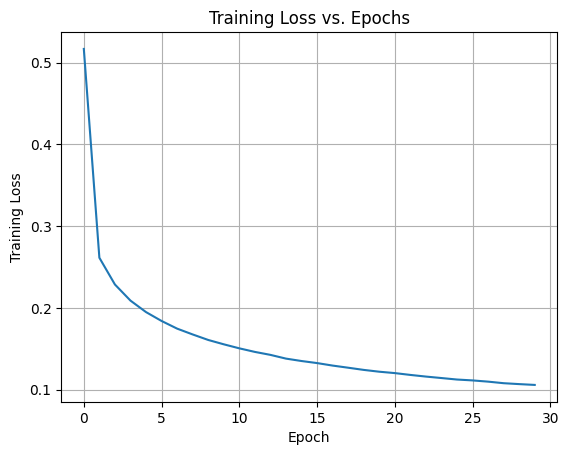

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Load the training loss array from a .npy file
training_loss = np.load('/kaggle/working/train_loss_20_50.npy')

# Plot the training loss
plt.plot(training_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.show()
